In [20]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from __future__ import print_function
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers, initializers
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [21]:
def getFormat(df, train_raw, window_size, stride):
    x = []
    for i in df:
        x.append(train_raw[i + 750 : i + 1750])
    x = np.array(x)
    x = x.reshape(-1, x.shape[2])
    upsample = []
    for i in range(0, len(x), stride):
        if(i + window_size <= len(x)):
            upsample.append(np.array(x[i: i + window_size]))
    return np.array(upsample)

def getData(subject, window_size, stride):
    train_raw = pd.read_csv("data/" + subject + "_data.csv", header=None).fillna(method='ffill').values
    print(train_raw.shape)
    markers_raw = pd.read_csv("data/" + subject + "_markers.csv", header=None)
    markers_raw.dropna(inplace=True)
    markers_raw.reset_index(drop=True, inplace=True)
    
    mr1 = markers_raw[markers_raw[1] == 1][0]
    mr2 = markers_raw[markers_raw[1] == 2][0]
    mr3 = markers_raw[markers_raw[1] == 3][0]
    mr4 = markers_raw[markers_raw[1] == 4][0]
  
    X1, X2, X3, X4 = [getFormat(mr, train_raw, window_size, stride) for mr in [mr1, mr2, mr3, mr4]]
    Y = [0] * len(X1) + [1] * len(X2) + [2] * len(X3) + [3] * len(X4)
  
  
    X = np.append(X1, X2, axis = 0)
    X = np.append(X, X3, axis = 0)
    X = np.append(X, X4, axis = 0)
  
    print(X.shape)
    scalers = {}
    for i in range(X.shape[2]):
        scalers[i] = preprocessing.StandardScaler()
        X[:, :, i] = scalers[i].fit_transform(X[:, :, i])

    return X, Y

In [38]:
def getReport(y_train, y_test, y_tr_pred, y_pred):
    accuracy = accuracy_score(np.argmax(y_pred, axis=1), y_test)
    tr_accuracy = accuracy_score(np.argmax(y_tr_pred, axis=1), y_train)
    precision = precision_score(np.argmax(y_pred, axis=1), y_test, average=None)
    recall = recall_score(np.argmax(y_pred, axis=1), y_test, average=None)
    f1 = f1_score(np.argmax(y_pred, axis=1),y_test, average=None)
    rmse = mean_squared_error(np.argmax(y_pred, axis=1),y_test)
    print({"rmse": rmse, "tr_acc": tr_accuracy, "acc": accuracy, "pre": precision, "rec": recall, "f1s": f1})

    return accuracy, tr_accuracy, precision, recall, f1, rmse

In [40]:
def createmodel(input_shape):
    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape, return_sequences=True, kernel_initializer=initializers.he_normal(), kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(LSTM(32, kernel_initializer=initializers.he_normal(), kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Dense(4, activation='softmax', kernel_initializer=initializers.he_normal()))

    model.summary()
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [41]:
def cnn(subject, X_train, X_test, y_train, y_test, epochs=200, batch=128):
    input_shape = X_train[0].shape
    model = createmodel(input_shape)
    filepath="weights/LSTM/new/32-0.3-32-0.4--" + subject + "-weights.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch,
                            shuffle=True,
                            validation_data=[X_test, y_test],
                            callbacks=callbacks_list,
                            verbose=2)
    bestmodel = load_model(filepath)
    return bestmodel

In [42]:
def runmodel(subject, epochs=200, batch=64, window_size=125, stride=100):
    X, y = getData(subject, window_size=window_size, stride=stride)
    y = np.array(y)
    seed = 7
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    cvscores = []
    tr_acc, acc, pre, rec, f, rms = 0, 0, 0, 0, 0, 0
    for train, test in kfold.split(X, y):
        y_train = to_categorical(y[train])
        y_test = to_categorical(y[test])
        model = cnn(subject, X[train], 
                              X[test], 
                              y_train, 
                              y_test, epochs, batch)
        y_pred = model.predict(X[test])
        y_tr_pred = model.predict(X[train])

        accuracy, tr_accuracy, precision, recall, f1, rmse = getReport(y[train], y[test], y_tr_pred, y_pred)
        return {"rmse": rmse, "tr_acc": tr_accuracy, "acc": accuracy, "pre": precision, "rec": recall, "f1s": f1}
        rms = rms + rmse / 10
        tr_acc = tr_acc + tr_accuracy / 10
        acc = acc + accuracy / 10
        rec = rec + recall / 10
        pre = pre + precision / 10
        f = f + f1 / 10
        break
    return {"rmse": rms, "tr_acc": tr_acc, "acc": acc, "pre": pre, "rec": rec, "f1s": f}

In [43]:
reports = []
for subject in ['k3b', 'k6b', 'l1b'] :
    report = {
      "subject": subject,
      "report": runmodel(subject, epochs=500, batch=64, window_size=250, stride=150)
    }
    reports.append(report)

(986780, 60)
(1196, 250, 60)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 250, 32)           11904     
_________________________________________________________________
dropout_4 (Dropout)          (None, 250, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 132       
Total params: 20,356
Trainable params: 20,356
Non-trainable params: 0
_________________________________________________________________
Train on 1076 samples, validate on 120 samples
Epoch 1/500
 - 27s - loss: 6.3441 - acc: 0.2481 - val_loss: 5.


Epoch 00049: val_acc did not improve from 0.54167
Epoch 50/500
 - 20s - loss: 1.6330 - acc: 0.4294 - val_loss: 1.5213 - val_acc: 0.5000

Epoch 00050: val_acc did not improve from 0.54167
Epoch 51/500
 - 21s - loss: 1.5354 - acc: 0.4712 - val_loss: 1.4435 - val_acc: 0.5583

Epoch 00051: val_acc improved from 0.54167 to 0.55833, saving model to weights/LSTM/new/32-0.3-32-0.4--k3b-weights.hdf5
Epoch 52/500
 - 21s - loss: 1.5541 - acc: 0.4675 - val_loss: 1.6062 - val_acc: 0.4500

Epoch 00052: val_acc did not improve from 0.55833
Epoch 53/500
 - 22s - loss: 1.5859 - acc: 0.4489 - val_loss: 1.5216 - val_acc: 0.4583

Epoch 00053: val_acc did not improve from 0.55833
Epoch 54/500
 - 24s - loss: 1.5614 - acc: 0.4554 - val_loss: 1.5684 - val_acc: 0.4833

Epoch 00054: val_acc did not improve from 0.55833
Epoch 55/500
 - 22s - loss: 1.5768 - acc: 0.4322 - val_loss: 1.5386 - val_acc: 0.4667

Epoch 00055: val_acc did not improve from 0.55833
Epoch 56/500
 - 21s - loss: 1.5225 - acc: 0.4647 - val_lo

 - 22s - loss: 1.6712 - acc: 0.2788 - val_loss: 1.6562 - val_acc: 0.3500

Epoch 00109: val_acc did not improve from 0.55833
Epoch 110/500
 - 22s - loss: 1.6681 - acc: 0.2974 - val_loss: 1.6513 - val_acc: 0.3667

Epoch 00110: val_acc did not improve from 0.55833
Epoch 111/500
 - 23s - loss: 1.6666 - acc: 0.2825 - val_loss: 1.6462 - val_acc: 0.3917

Epoch 00111: val_acc did not improve from 0.55833
Epoch 112/500
 - 23s - loss: 1.6557 - acc: 0.2946 - val_loss: 1.6394 - val_acc: 0.3583

Epoch 00112: val_acc did not improve from 0.55833
Epoch 113/500
 - 23s - loss: 1.6417 - acc: 0.3262 - val_loss: 1.6324 - val_acc: 0.3667

Epoch 00113: val_acc did not improve from 0.55833
Epoch 114/500
 - 26s - loss: 1.6388 - acc: 0.3346 - val_loss: 1.6250 - val_acc: 0.3500

Epoch 00114: val_acc did not improve from 0.55833
Epoch 115/500
 - 24s - loss: 1.6345 - acc: 0.3309 - val_loss: 1.6077 - val_acc: 0.3750

Epoch 00115: val_acc did not improve from 0.55833
Epoch 116/500
 - 25s - loss: 1.6151 - acc: 0.349

 - 29s - loss: 1.4235 - acc: 0.4284 - val_loss: 1.3360 - val_acc: 0.5000

Epoch 00168: val_acc did not improve from 0.59167
Epoch 169/500
 - 39s - loss: 1.3759 - acc: 0.4517 - val_loss: 1.3181 - val_acc: 0.5500

Epoch 00169: val_acc did not improve from 0.59167
Epoch 170/500
 - 20s - loss: 1.3273 - acc: 0.4693 - val_loss: 1.2598 - val_acc: 0.4917

Epoch 00170: val_acc did not improve from 0.59167
Epoch 171/500
 - 27s - loss: 1.2897 - acc: 0.4926 - val_loss: 1.2142 - val_acc: 0.4917

Epoch 00171: val_acc did not improve from 0.59167
Epoch 172/500
 - 29s - loss: 1.3264 - acc: 0.4712 - val_loss: 1.2112 - val_acc: 0.5167

Epoch 00172: val_acc did not improve from 0.59167
Epoch 173/500
 - 31s - loss: 1.4753 - acc: 0.4331 - val_loss: 1.8592 - val_acc: 0.2917

Epoch 00173: val_acc did not improve from 0.59167
Epoch 174/500
 - 28s - loss: 1.8072 - acc: 0.2704 - val_loss: 1.6436 - val_acc: 0.2417

Epoch 00174: val_acc did not improve from 0.59167
Epoch 175/500
 - 28s - loss: 1.6261 - acc: 0.294


Epoch 00227: val_acc did not improve from 0.59167
Epoch 228/500
 - 24s - loss: 1.2490 - acc: 0.4647 - val_loss: 1.1861 - val_acc: 0.5500

Epoch 00228: val_acc did not improve from 0.59167
Epoch 229/500
 - 23s - loss: 1.2288 - acc: 0.4907 - val_loss: 1.1518 - val_acc: 0.5333

Epoch 00229: val_acc did not improve from 0.59167
Epoch 230/500
 - 23s - loss: 1.2029 - acc: 0.4991 - val_loss: 1.1236 - val_acc: 0.5333

Epoch 00230: val_acc did not improve from 0.59167
Epoch 231/500
 - 20s - loss: 1.1930 - acc: 0.4861 - val_loss: 1.1445 - val_acc: 0.5667

Epoch 00231: val_acc did not improve from 0.59167
Epoch 232/500
 - 21s - loss: 1.1791 - acc: 0.5316 - val_loss: 1.1243 - val_acc: 0.5417

Epoch 00232: val_acc did not improve from 0.59167
Epoch 233/500
 - 22s - loss: 1.2147 - acc: 0.4879 - val_loss: 1.1984 - val_acc: 0.4667

Epoch 00233: val_acc did not improve from 0.59167
Epoch 234/500
 - 23s - loss: 1.2520 - acc: 0.4805 - val_loss: 1.1809 - val_acc: 0.5000

Epoch 00234: val_acc did not impr

 - 26s - loss: 1.5188 - acc: 0.3290 - val_loss: 1.4718 - val_acc: 0.3500

Epoch 00287: val_acc did not improve from 0.59167
Epoch 288/500
 - 22s - loss: 1.4978 - acc: 0.3392 - val_loss: 1.4455 - val_acc: 0.3750

Epoch 00288: val_acc did not improve from 0.59167
Epoch 289/500
 - 19s - loss: 1.4732 - acc: 0.3745 - val_loss: 1.4278 - val_acc: 0.3750

Epoch 00289: val_acc did not improve from 0.59167
Epoch 290/500
 - 19s - loss: 1.4472 - acc: 0.3950 - val_loss: 1.4029 - val_acc: 0.4000

Epoch 00290: val_acc did not improve from 0.59167
Epoch 291/500
 - 19s - loss: 1.4295 - acc: 0.3848 - val_loss: 1.3791 - val_acc: 0.4333

Epoch 00291: val_acc did not improve from 0.59167
Epoch 292/500
 - 20s - loss: 1.4179 - acc: 0.3717 - val_loss: 1.3700 - val_acc: 0.4333

Epoch 00292: val_acc did not improve from 0.59167
Epoch 293/500
 - 22s - loss: 1.3957 - acc: 0.4015 - val_loss: 1.3465 - val_acc: 0.4333

Epoch 00293: val_acc did not improve from 0.59167
Epoch 294/500
 - 21s - loss: 1.3780 - acc: 0.402


Epoch 00346: val_acc did not improve from 0.59167
Epoch 347/500
 - 24s - loss: 1.2023 - acc: 0.4489 - val_loss: 1.2248 - val_acc: 0.4667

Epoch 00347: val_acc did not improve from 0.59167
Epoch 348/500
 - 23s - loss: 1.1900 - acc: 0.4684 - val_loss: 1.1823 - val_acc: 0.4833

Epoch 00348: val_acc did not improve from 0.59167
Epoch 349/500
 - 21s - loss: 1.2029 - acc: 0.4433 - val_loss: 1.2477 - val_acc: 0.4167

Epoch 00349: val_acc did not improve from 0.59167
Epoch 350/500
 - 22s - loss: 1.1849 - acc: 0.4684 - val_loss: 1.2126 - val_acc: 0.5167

Epoch 00350: val_acc did not improve from 0.59167
Epoch 351/500
 - 21s - loss: 1.1758 - acc: 0.4563 - val_loss: 1.2143 - val_acc: 0.4583

Epoch 00351: val_acc did not improve from 0.59167
Epoch 352/500
 - 23s - loss: 1.2287 - acc: 0.4758 - val_loss: 1.2494 - val_acc: 0.4500

Epoch 00352: val_acc did not improve from 0.59167
Epoch 353/500
 - 21s - loss: 1.2026 - acc: 0.4442 - val_loss: 1.2489 - val_acc: 0.4417

Epoch 00353: val_acc did not impr

 - 19s - loss: 1.1739 - acc: 0.4554 - val_loss: 1.2156 - val_acc: 0.4333

Epoch 00406: val_acc did not improve from 0.59167
Epoch 407/500
 - 18s - loss: 1.3856 - acc: 0.3894 - val_loss: 1.2703 - val_acc: 0.4000

Epoch 00407: val_acc did not improve from 0.59167
Epoch 408/500
 - 19s - loss: 1.2666 - acc: 0.4312 - val_loss: 1.2171 - val_acc: 0.4833

Epoch 00408: val_acc did not improve from 0.59167
Epoch 409/500
 - 18s - loss: 1.2350 - acc: 0.4359 - val_loss: 1.2340 - val_acc: 0.4667

Epoch 00409: val_acc did not improve from 0.59167
Epoch 410/500
 - 20s - loss: 1.2117 - acc: 0.4247 - val_loss: 1.2187 - val_acc: 0.4667

Epoch 00410: val_acc did not improve from 0.59167
Epoch 411/500
 - 24s - loss: 1.2048 - acc: 0.4424 - val_loss: 1.2218 - val_acc: 0.4750

Epoch 00411: val_acc did not improve from 0.59167
Epoch 412/500
 - 22s - loss: 1.1982 - acc: 0.4349 - val_loss: 1.2411 - val_acc: 0.4667

Epoch 00412: val_acc did not improve from 0.59167
Epoch 413/500
 - 19s - loss: 1.1730 - acc: 0.456


Epoch 00465: val_acc did not improve from 0.59167
Epoch 466/500
 - 18s - loss: 1.4398 - acc: 0.3773 - val_loss: 1.3777 - val_acc: 0.4167

Epoch 00466: val_acc did not improve from 0.59167
Epoch 467/500
 - 19s - loss: 1.4146 - acc: 0.3866 - val_loss: 1.3498 - val_acc: 0.3917

Epoch 00467: val_acc did not improve from 0.59167
Epoch 468/500
 - 18s - loss: 1.4028 - acc: 0.3625 - val_loss: 1.3219 - val_acc: 0.4083

Epoch 00468: val_acc did not improve from 0.59167
Epoch 469/500
 - 18s - loss: 1.3845 - acc: 0.4043 - val_loss: 1.2991 - val_acc: 0.4167

Epoch 00469: val_acc did not improve from 0.59167
Epoch 470/500
 - 18s - loss: 1.3570 - acc: 0.4377 - val_loss: 1.2879 - val_acc: 0.4417

Epoch 00470: val_acc did not improve from 0.59167
Epoch 471/500
 - 19s - loss: 1.3389 - acc: 0.3875 - val_loss: 1.2372 - val_acc: 0.4833

Epoch 00471: val_acc did not improve from 0.59167
Epoch 472/500
 - 20s - loss: 1.3244 - acc: 0.4284 - val_loss: 1.2568 - val_acc: 0.5250

Epoch 00472: val_acc did not impr


Epoch 00014: val_acc did not improve from 0.27500
Epoch 15/500
 - 12s - loss: 3.0757 - acc: 0.3561 - val_loss: 3.0740 - val_acc: 0.2500

Epoch 00015: val_acc did not improve from 0.27500
Epoch 16/500
 - 13s - loss: 2.9555 - acc: 0.3575 - val_loss: 2.9630 - val_acc: 0.2250

Epoch 00016: val_acc did not improve from 0.27500
Epoch 17/500
 - 13s - loss: 2.8125 - acc: 0.3966 - val_loss: 2.8589 - val_acc: 0.2375

Epoch 00017: val_acc did not improve from 0.27500
Epoch 18/500
 - 13s - loss: 2.7157 - acc: 0.3645 - val_loss: 2.7642 - val_acc: 0.2250

Epoch 00018: val_acc did not improve from 0.27500
Epoch 19/500
 - 13s - loss: 2.6049 - acc: 0.3729 - val_loss: 2.6673 - val_acc: 0.2375

Epoch 00019: val_acc did not improve from 0.27500
Epoch 20/500
 - 12s - loss: 2.4901 - acc: 0.3771 - val_loss: 2.5841 - val_acc: 0.2625

Epoch 00020: val_acc did not improve from 0.27500
Epoch 21/500
 - 12s - loss: 2.4088 - acc: 0.3953 - val_loss: 2.5356 - val_acc: 0.1875

Epoch 00021: val_acc did not improve fro


Epoch 00073: val_acc did not improve from 0.37500
Epoch 74/500
 - 13s - loss: 0.9020 - acc: 0.7346 - val_loss: 2.3229 - val_acc: 0.3250

Epoch 00074: val_acc did not improve from 0.37500
Epoch 75/500
 - 13s - loss: 0.9036 - acc: 0.7388 - val_loss: 2.2951 - val_acc: 0.3250

Epoch 00075: val_acc did not improve from 0.37500
Epoch 76/500
 - 12s - loss: 0.8840 - acc: 0.7277 - val_loss: 2.3237 - val_acc: 0.3125

Epoch 00076: val_acc did not improve from 0.37500
Epoch 77/500
 - 13s - loss: 0.8718 - acc: 0.7486 - val_loss: 2.1399 - val_acc: 0.3625

Epoch 00077: val_acc did not improve from 0.37500
Epoch 78/500
 - 12s - loss: 0.8060 - acc: 0.7779 - val_loss: 2.2811 - val_acc: 0.3125

Epoch 00078: val_acc did not improve from 0.37500
Epoch 79/500
 - 13s - loss: 0.8216 - acc: 0.7737 - val_loss: 2.2662 - val_acc: 0.4000

Epoch 00079: val_acc improved from 0.37500 to 0.40000, saving model to weights/LSTM/new/32-0.3-32-0.4--k6b-weights.hdf5
Epoch 80/500
 - 13s - loss: 0.9126 - acc: 0.7360 - val_lo


Epoch 00132: val_acc did not improve from 0.41250
Epoch 133/500
 - 12s - loss: 0.5894 - acc: 0.8855 - val_loss: 2.5674 - val_acc: 0.3625

Epoch 00133: val_acc did not improve from 0.41250
Epoch 134/500
 - 12s - loss: 0.5523 - acc: 0.9078 - val_loss: 2.6845 - val_acc: 0.3500

Epoch 00134: val_acc did not improve from 0.41250
Epoch 135/500
 - 12s - loss: 0.5654 - acc: 0.8883 - val_loss: 2.5080 - val_acc: 0.4125

Epoch 00135: val_acc did not improve from 0.41250
Epoch 136/500
 - 12s - loss: 0.5865 - acc: 0.8855 - val_loss: 2.9207 - val_acc: 0.4000

Epoch 00136: val_acc did not improve from 0.41250
Epoch 137/500
 - 13s - loss: 0.7681 - acc: 0.7975 - val_loss: 2.5337 - val_acc: 0.3625

Epoch 00137: val_acc did not improve from 0.41250
Epoch 138/500
 - 12s - loss: 0.7913 - acc: 0.8087 - val_loss: 2.9342 - val_acc: 0.3250

Epoch 00138: val_acc did not improve from 0.41250
Epoch 139/500
 - 12s - loss: 0.9280 - acc: 0.7612 - val_loss: 2.4672 - val_acc: 0.3375

Epoch 00139: val_acc did not impr

 - 13s - loss: 0.3716 - acc: 0.9525 - val_loss: 3.4998 - val_acc: 0.3375

Epoch 00192: val_acc did not improve from 0.41250
Epoch 193/500
 - 12s - loss: 0.4910 - acc: 0.9232 - val_loss: 3.5360 - val_acc: 0.3125

Epoch 00193: val_acc did not improve from 0.41250
Epoch 194/500
 - 12s - loss: 0.4689 - acc: 0.9190 - val_loss: 3.5315 - val_acc: 0.3625

Epoch 00194: val_acc did not improve from 0.41250
Epoch 195/500
 - 12s - loss: 0.4034 - acc: 0.9427 - val_loss: 3.6038 - val_acc: 0.2875

Epoch 00195: val_acc did not improve from 0.41250
Epoch 196/500
 - 13s - loss: 0.3694 - acc: 0.9539 - val_loss: 3.5433 - val_acc: 0.3125

Epoch 00196: val_acc did not improve from 0.41250
Epoch 197/500
 - 12s - loss: 0.3602 - acc: 0.9609 - val_loss: 3.4646 - val_acc: 0.3875

Epoch 00197: val_acc did not improve from 0.41250
Epoch 198/500
 - 13s - loss: 0.3965 - acc: 0.9511 - val_loss: 3.4388 - val_acc: 0.3375

Epoch 00198: val_acc did not improve from 0.41250
Epoch 199/500
 - 12s - loss: 0.4313 - acc: 0.935

 - 12s - loss: 0.4500 - acc: 0.9092 - val_loss: 3.4856 - val_acc: 0.4000

Epoch 00251: val_acc did not improve from 0.42500
Epoch 252/500
 - 13s - loss: 0.4238 - acc: 0.9232 - val_loss: 3.4347 - val_acc: 0.3875

Epoch 00252: val_acc did not improve from 0.42500
Epoch 253/500
 - 13s - loss: 0.4128 - acc: 0.9372 - val_loss: 3.2643 - val_acc: 0.4125

Epoch 00253: val_acc did not improve from 0.42500
Epoch 254/500
 - 12s - loss: 0.5116 - acc: 0.9022 - val_loss: 3.2734 - val_acc: 0.3750

Epoch 00254: val_acc did not improve from 0.42500
Epoch 255/500
 - 12s - loss: 0.4731 - acc: 0.9092 - val_loss: 3.2012 - val_acc: 0.4000

Epoch 00255: val_acc did not improve from 0.42500
Epoch 256/500
 - 12s - loss: 0.3870 - acc: 0.9469 - val_loss: 3.3318 - val_acc: 0.3625

Epoch 00256: val_acc did not improve from 0.42500
Epoch 257/500
 - 13s - loss: 0.3541 - acc: 0.9539 - val_loss: 3.4564 - val_acc: 0.3750

Epoch 00257: val_acc did not improve from 0.42500
Epoch 258/500
 - 12s - loss: 0.2915 - acc: 0.981


Epoch 00309: val_acc did not improve from 0.45000
Epoch 310/500
 - 12s - loss: 0.3852 - acc: 0.9344 - val_loss: 3.4966 - val_acc: 0.3750

Epoch 00310: val_acc did not improve from 0.45000
Epoch 311/500
 - 12s - loss: 0.2769 - acc: 0.9749 - val_loss: 3.3583 - val_acc: 0.4000

Epoch 00311: val_acc did not improve from 0.45000
Epoch 312/500
 - 12s - loss: 0.3119 - acc: 0.9637 - val_loss: 3.7150 - val_acc: 0.3375

Epoch 00312: val_acc did not improve from 0.45000
Epoch 313/500
 - 12s - loss: 0.2707 - acc: 0.9791 - val_loss: 3.5758 - val_acc: 0.4000

Epoch 00313: val_acc did not improve from 0.45000
Epoch 314/500
 - 13s - loss: 0.2361 - acc: 0.9860 - val_loss: 3.4776 - val_acc: 0.4000

Epoch 00314: val_acc did not improve from 0.45000
Epoch 315/500
 - 13s - loss: 0.2427 - acc: 0.9832 - val_loss: 3.5470 - val_acc: 0.3875

Epoch 00315: val_acc did not improve from 0.45000
Epoch 316/500
 - 13s - loss: 0.2261 - acc: 0.9944 - val_loss: 3.5566 - val_acc: 0.3625

Epoch 00316: val_acc did not impr

 - 12s - loss: 0.3289 - acc: 0.9525 - val_loss: 3.8934 - val_acc: 0.3750

Epoch 00369: val_acc did not improve from 0.45000
Epoch 370/500
 - 12s - loss: 0.3144 - acc: 0.9595 - val_loss: 3.7068 - val_acc: 0.3750

Epoch 00370: val_acc did not improve from 0.45000
Epoch 371/500
 - 12s - loss: 0.2689 - acc: 0.9818 - val_loss: 3.8333 - val_acc: 0.3375

Epoch 00371: val_acc did not improve from 0.45000
Epoch 372/500
 - 13s - loss: 0.2708 - acc: 0.9735 - val_loss: 3.7683 - val_acc: 0.3375

Epoch 00372: val_acc did not improve from 0.45000
Epoch 373/500
 - 13s - loss: 0.2720 - acc: 0.9693 - val_loss: 3.6782 - val_acc: 0.3625

Epoch 00373: val_acc did not improve from 0.45000
Epoch 374/500
 - 12s - loss: 0.2442 - acc: 0.9846 - val_loss: 3.8334 - val_acc: 0.3875

Epoch 00374: val_acc did not improve from 0.45000
Epoch 375/500
 - 12s - loss: 0.2505 - acc: 0.9791 - val_loss: 3.9746 - val_acc: 0.4000

Epoch 00375: val_acc did not improve from 0.45000
Epoch 376/500
 - 13s - loss: 0.2305 - acc: 0.981


Epoch 00428: val_acc did not improve from 0.45000
Epoch 429/500
 - 12s - loss: 0.3502 - acc: 0.9413 - val_loss: 3.9056 - val_acc: 0.3750

Epoch 00429: val_acc did not improve from 0.45000
Epoch 430/500
 - 13s - loss: 0.3114 - acc: 0.9497 - val_loss: 4.0639 - val_acc: 0.3250

Epoch 00430: val_acc did not improve from 0.45000
Epoch 431/500
 - 12s - loss: 0.2906 - acc: 0.9623 - val_loss: 4.1604 - val_acc: 0.3250

Epoch 00431: val_acc did not improve from 0.45000
Epoch 432/500
 - 12s - loss: 0.2761 - acc: 0.9623 - val_loss: 4.0135 - val_acc: 0.3250

Epoch 00432: val_acc did not improve from 0.45000
Epoch 433/500
 - 12s - loss: 0.2685 - acc: 0.9665 - val_loss: 3.6725 - val_acc: 0.3500

Epoch 00433: val_acc did not improve from 0.45000
Epoch 434/500
 - 12s - loss: 0.3185 - acc: 0.9567 - val_loss: 4.1717 - val_acc: 0.3250

Epoch 00434: val_acc did not improve from 0.45000
Epoch 435/500
 - 13s - loss: 0.3351 - acc: 0.9441 - val_loss: 4.1140 - val_acc: 0.3125

Epoch 00435: val_acc did not impr

 - 12s - loss: 0.2079 - acc: 0.9916 - val_loss: 4.1931 - val_acc: 0.3250

Epoch 00488: val_acc did not improve from 0.45000
Epoch 489/500
 - 12s - loss: 0.1994 - acc: 0.9944 - val_loss: 4.1800 - val_acc: 0.3125

Epoch 00489: val_acc did not improve from 0.45000
Epoch 490/500
 - 13s - loss: 0.1902 - acc: 0.9972 - val_loss: 4.3122 - val_acc: 0.3000

Epoch 00490: val_acc did not improve from 0.45000
Epoch 491/500
 - 12s - loss: 0.1947 - acc: 0.9944 - val_loss: 4.1115 - val_acc: 0.3000

Epoch 00491: val_acc did not improve from 0.45000
Epoch 492/500
 - 12s - loss: 0.1929 - acc: 0.9930 - val_loss: 4.0911 - val_acc: 0.3250

Epoch 00492: val_acc did not improve from 0.45000
Epoch 493/500
 - 13s - loss: 0.1855 - acc: 0.9930 - val_loss: 4.2056 - val_acc: 0.3250

Epoch 00493: val_acc did not improve from 0.45000
Epoch 494/500
 - 13s - loss: 0.1772 - acc: 0.9958 - val_loss: 4.2580 - val_acc: 0.3375

Epoch 00494: val_acc did not improve from 0.45000
Epoch 495/500
 - 12s - loss: 0.1756 - acc: 0.997


Epoch 00036: val_acc did not improve from 0.33750
Epoch 37/500
 - 12s - loss: 1.6241 - acc: 0.5070 - val_loss: 2.0098 - val_acc: 0.3375

Epoch 00037: val_acc did not improve from 0.33750
Epoch 38/500
 - 12s - loss: 1.6053 - acc: 0.4846 - val_loss: 1.9406 - val_acc: 0.3125

Epoch 00038: val_acc did not improve from 0.33750
Epoch 39/500
 - 12s - loss: 1.5895 - acc: 0.4818 - val_loss: 1.9309 - val_acc: 0.3750

Epoch 00039: val_acc improved from 0.33750 to 0.37500, saving model to weights/LSTM/new/32-0.3-32-0.4--l1b-weights.hdf5
Epoch 40/500
 - 12s - loss: 1.5770 - acc: 0.5042 - val_loss: 2.0266 - val_acc: 0.2625

Epoch 00040: val_acc did not improve from 0.37500
Epoch 41/500
 - 12s - loss: 1.5702 - acc: 0.4846 - val_loss: 1.9148 - val_acc: 0.3750

Epoch 00041: val_acc did not improve from 0.37500
Epoch 42/500
 - 12s - loss: 1.5245 - acc: 0.5084 - val_loss: 1.9064 - val_acc: 0.3000

Epoch 00042: val_acc did not improve from 0.37500
Epoch 43/500
 - 14s - loss: 1.4640 - acc: 0.5433 - val_lo

 - 13s - loss: 0.7479 - acc: 0.8115 - val_loss: 2.7386 - val_acc: 0.2375

Epoch 00096: val_acc did not improve from 0.37500
Epoch 97/500
 - 13s - loss: 0.7636 - acc: 0.8240 - val_loss: 2.6538 - val_acc: 0.2500

Epoch 00097: val_acc did not improve from 0.37500
Epoch 98/500
 - 13s - loss: 0.7418 - acc: 0.8282 - val_loss: 2.8572 - val_acc: 0.2500

Epoch 00098: val_acc did not improve from 0.37500
Epoch 99/500
 - 13s - loss: 0.7017 - acc: 0.8450 - val_loss: 2.9601 - val_acc: 0.2375

Epoch 00099: val_acc did not improve from 0.37500
Epoch 100/500
 - 13s - loss: 0.6910 - acc: 0.8506 - val_loss: 2.8112 - val_acc: 0.2625

Epoch 00100: val_acc did not improve from 0.37500
Epoch 101/500
 - 12s - loss: 0.9020 - acc: 0.7458 - val_loss: 2.7950 - val_acc: 0.2500

Epoch 00101: val_acc did not improve from 0.37500
Epoch 102/500
 - 12s - loss: 0.9231 - acc: 0.7430 - val_loss: 2.4661 - val_acc: 0.3250

Epoch 00102: val_acc did not improve from 0.37500
Epoch 103/500
 - 12s - loss: 0.7585 - acc: 0.8170 -

 - 12s - loss: 0.5243 - acc: 0.9064 - val_loss: 3.2768 - val_acc: 0.3750

Epoch 00155: val_acc did not improve from 0.40000
Epoch 156/500
 - 12s - loss: 0.4439 - acc: 0.9358 - val_loss: 3.3919 - val_acc: 0.3000

Epoch 00156: val_acc did not improve from 0.40000
Epoch 157/500
 - 12s - loss: 0.4569 - acc: 0.9344 - val_loss: 3.1139 - val_acc: 0.2625

Epoch 00157: val_acc did not improve from 0.40000
Epoch 158/500
 - 12s - loss: 0.4533 - acc: 0.9358 - val_loss: 3.3558 - val_acc: 0.3000

Epoch 00158: val_acc did not improve from 0.40000
Epoch 159/500
 - 13s - loss: 0.4580 - acc: 0.9218 - val_loss: 3.2036 - val_acc: 0.3375

Epoch 00159: val_acc did not improve from 0.40000
Epoch 160/500
 - 12s - loss: 0.4537 - acc: 0.9372 - val_loss: 3.2454 - val_acc: 0.2750

Epoch 00160: val_acc did not improve from 0.40000
Epoch 161/500
 - 12s - loss: 0.5086 - acc: 0.9064 - val_loss: 3.4458 - val_acc: 0.3375

Epoch 00161: val_acc did not improve from 0.40000
Epoch 162/500
 - 12s - loss: 0.5133 - acc: 0.919


Epoch 00214: val_acc did not improve from 0.40000
Epoch 215/500
 - 12s - loss: 0.3354 - acc: 0.9693 - val_loss: 3.7916 - val_acc: 0.2875

Epoch 00215: val_acc did not improve from 0.40000
Epoch 216/500
 - 13s - loss: 0.4070 - acc: 0.9469 - val_loss: 3.7864 - val_acc: 0.3125

Epoch 00216: val_acc did not improve from 0.40000
Epoch 217/500
 - 13s - loss: 0.3801 - acc: 0.9525 - val_loss: 3.9074 - val_acc: 0.3125

Epoch 00217: val_acc did not improve from 0.40000
Epoch 218/500
 - 12s - loss: 0.4030 - acc: 0.9455 - val_loss: 4.0231 - val_acc: 0.2375

Epoch 00218: val_acc did not improve from 0.40000
Epoch 219/500
 - 13s - loss: 0.4009 - acc: 0.9302 - val_loss: 3.7296 - val_acc: 0.2875

Epoch 00219: val_acc did not improve from 0.40000
Epoch 220/500
 - 13s - loss: 0.3533 - acc: 0.9567 - val_loss: 3.6081 - val_acc: 0.2750

Epoch 00220: val_acc did not improve from 0.40000
Epoch 221/500
 - 13s - loss: 0.4271 - acc: 0.9399 - val_loss: 4.0327 - val_acc: 0.2875

Epoch 00221: val_acc did not impr

 - 13s - loss: 0.2679 - acc: 0.9874 - val_loss: 4.1192 - val_acc: 0.3125

Epoch 00274: val_acc did not improve from 0.40000
Epoch 275/500
 - 15s - loss: 0.2836 - acc: 0.9818 - val_loss: 4.2424 - val_acc: 0.3125

Epoch 00275: val_acc did not improve from 0.40000
Epoch 276/500
 - 12s - loss: 0.2671 - acc: 0.9832 - val_loss: 4.1938 - val_acc: 0.3000

Epoch 00276: val_acc did not improve from 0.40000
Epoch 277/500
 - 13s - loss: 0.3000 - acc: 0.9749 - val_loss: 4.2367 - val_acc: 0.2875

Epoch 00277: val_acc did not improve from 0.40000
Epoch 278/500
 - 13s - loss: 0.2736 - acc: 0.9791 - val_loss: 4.2352 - val_acc: 0.3000

Epoch 00278: val_acc did not improve from 0.40000
Epoch 279/500
 - 13s - loss: 0.2879 - acc: 0.9777 - val_loss: 4.2500 - val_acc: 0.3500

Epoch 00279: val_acc did not improve from 0.40000
Epoch 280/500
 - 13s - loss: 0.2480 - acc: 0.9916 - val_loss: 4.0877 - val_acc: 0.3625

Epoch 00280: val_acc did not improve from 0.40000
Epoch 281/500
 - 13s - loss: 0.2563 - acc: 0.987


Epoch 00333: val_acc did not improve from 0.40000
Epoch 334/500
 - 13s - loss: 0.2535 - acc: 0.9874 - val_loss: 4.0700 - val_acc: 0.3125

Epoch 00334: val_acc did not improve from 0.40000
Epoch 335/500
 - 12s - loss: 0.2529 - acc: 0.9888 - val_loss: 4.0783 - val_acc: 0.3000

Epoch 00335: val_acc did not improve from 0.40000
Epoch 336/500
 - 13s - loss: 0.2397 - acc: 0.9902 - val_loss: 4.1752 - val_acc: 0.3000

Epoch 00336: val_acc did not improve from 0.40000
Epoch 337/500
 - 13s - loss: 0.2306 - acc: 0.9944 - val_loss: 4.1431 - val_acc: 0.3000

Epoch 00337: val_acc did not improve from 0.40000
Epoch 338/500
 - 12s - loss: 0.2342 - acc: 0.9902 - val_loss: 3.9242 - val_acc: 0.3750

Epoch 00338: val_acc did not improve from 0.40000
Epoch 339/500
 - 13s - loss: 0.2267 - acc: 0.9930 - val_loss: 3.9646 - val_acc: 0.3375

Epoch 00339: val_acc did not improve from 0.40000
Epoch 340/500
 - 13s - loss: 0.2246 - acc: 0.9944 - val_loss: 3.9855 - val_acc: 0.3125

Epoch 00340: val_acc did not impr

 - 12s - loss: 0.3831 - acc: 0.9372 - val_loss: 4.8558 - val_acc: 0.3125

Epoch 00393: val_acc did not improve from 0.40000
Epoch 394/500
 - 13s - loss: 0.4747 - acc: 0.9204 - val_loss: 4.4607 - val_acc: 0.3125

Epoch 00394: val_acc did not improve from 0.40000
Epoch 395/500
 - 13s - loss: 0.4299 - acc: 0.9134 - val_loss: 4.7249 - val_acc: 0.2875

Epoch 00395: val_acc did not improve from 0.40000
Epoch 396/500
 - 12s - loss: 0.4742 - acc: 0.9064 - val_loss: 4.3399 - val_acc: 0.3250

Epoch 00396: val_acc did not improve from 0.40000
Epoch 397/500
 - 12s - loss: 0.3324 - acc: 0.9483 - val_loss: 4.2290 - val_acc: 0.2875

Epoch 00397: val_acc did not improve from 0.40000
Epoch 398/500
 - 13s - loss: 0.4152 - acc: 0.9469 - val_loss: 4.0788 - val_acc: 0.3000

Epoch 00398: val_acc did not improve from 0.40000
Epoch 399/500
 - 13s - loss: 0.4176 - acc: 0.9232 - val_loss: 3.8877 - val_acc: 0.2750

Epoch 00399: val_acc did not improve from 0.40000
Epoch 400/500
 - 12s - loss: 0.3629 - acc: 0.935


Epoch 00452: val_acc did not improve from 0.40000
Epoch 453/500
 - 13s - loss: 0.2931 - acc: 0.9637 - val_loss: 4.1198 - val_acc: 0.3000

Epoch 00453: val_acc did not improve from 0.40000
Epoch 454/500
 - 13s - loss: 0.3841 - acc: 0.9358 - val_loss: 4.0084 - val_acc: 0.3500

Epoch 00454: val_acc did not improve from 0.40000
Epoch 455/500
 - 13s - loss: 0.3049 - acc: 0.9623 - val_loss: 4.3610 - val_acc: 0.3000

Epoch 00455: val_acc did not improve from 0.40000
Epoch 456/500
 - 14s - loss: 0.2884 - acc: 0.9707 - val_loss: 4.2796 - val_acc: 0.3000

Epoch 00456: val_acc did not improve from 0.40000
Epoch 457/500
 - 13s - loss: 0.2677 - acc: 0.9749 - val_loss: 4.6481 - val_acc: 0.2875

Epoch 00457: val_acc did not improve from 0.40000
Epoch 458/500
 - 13s - loss: 0.2621 - acc: 0.9735 - val_loss: 4.5788 - val_acc: 0.2875

Epoch 00458: val_acc did not improve from 0.40000
Epoch 459/500
 - 13s - loss: 0.2327 - acc: 0.9846 - val_loss: 4.3553 - val_acc: 0.3000

Epoch 00459: val_acc did not impr

In [44]:
reports

[{'subject': 'k3b',
  'report': {'rmse': 0.7416666666666667,
   'tr_acc': 0.483271375464684,
   'acc': 0.5916666666666667,
   'pre': array([0.7       , 0.5       , 0.9       , 0.26666667]),
   'rec': array([0.56756757, 0.57692308, 0.5625    , 0.88888889]),
   'f1s': array([0.62686567, 0.53571429, 0.69230769, 0.41025641])}},
 {'subject': 'k6b',
  'report': {'rmse': 1.975,
   'tr_acc': 0.9972067039106145,
   'acc': 0.45,
   'pre': array([0.4 , 0.55, 0.4 , 0.45]),
   'rec': array([0.42105263, 0.44      , 0.53333333, 0.42857143]),
   'f1s': array([0.41025641, 0.48888889, 0.45714286, 0.43902439])}},
 {'subject': 'l1b',
  'report': {'rmse': 1.7125,
   'tr_acc': 0.9399441340782123,
   'acc': 0.4,
   'pre': array([0.35, 0.55, 0.3 , 0.4 ]),
   'rec': array([0.53846154, 0.35483871, 0.375     , 0.4       ]),
   'f1s': array([0.42424242, 0.43137255, 0.33333333, 0.4       ])}}]

In [45]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
def plotRoc(y_test, y_score):
    lw=2
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 4
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=2)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
    arr = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_score, axis=1))
    arr = arr.astype('float') / arr.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(arr, index = [i for i in "1234"],
                  columns = [i for i in "1234"])
    sn.heatmap(df_cm, annot=True)
    plt.show()

In [54]:
def evaluate(subject, window_size, stride):
    X, y = getData(subject, window_size=window_size, stride=stride)
    y = np.array(y)
    seed = 7
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    cvscores = []
    tr_acc, acc, pre, rec, f, rms = 0, 0, 0, 0, 0, 0
    for train, test in kfold.split(X, y):
        y_train = to_categorical(y[train])
        y_test = to_categorical(y[test])
        filepath="weights/LSTM/new/32-0.3-32-0.4--" + subject + "-weights.hdf5"
        model = load_model(filepath)
        y_pred = model.predict(X[test])
        y_tr_pred = model.predict(X[train])
        accuracy, tr_accuracy, precision, recall, f1, rmse = getReport(y[train], y[test], y_tr_pred, y_pred)
        print(subject)
        del model
        plotRoc(y_test, y_pred)
        return({"rmse": rmse, "tr_acc": tr_accuracy, "acc": accuracy, "pre": precision, "rec": recall, "f1s": f1})
        break

(986780, 60)
(1196, 250, 60)
{'rmse': 0.7416666666666667, 'tr_acc': 0.483271375464684, 'acc': 0.5916666666666667, 'pre': array([0.7       , 0.5       , 0.9       , 0.26666667]), 'rec': array([0.56756757, 0.57692308, 0.5625    , 0.88888889]), 'f1s': array([0.62686567, 0.53571429, 0.69230769, 0.41025641])}
k3b


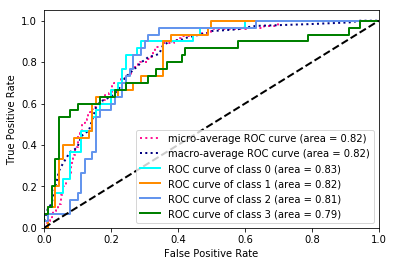

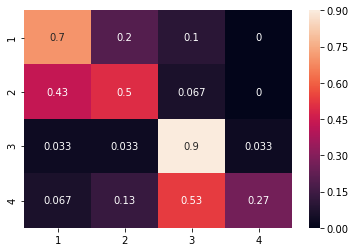

(631200, 60)
(796, 250, 60)
{'rmse': 1.975, 'tr_acc': 0.9972067039106145, 'acc': 0.45, 'pre': array([0.4 , 0.55, 0.4 , 0.45]), 'rec': array([0.42105263, 0.44      , 0.53333333, 0.42857143]), 'f1s': array([0.41025641, 0.48888889, 0.45714286, 0.43902439])}
k6b


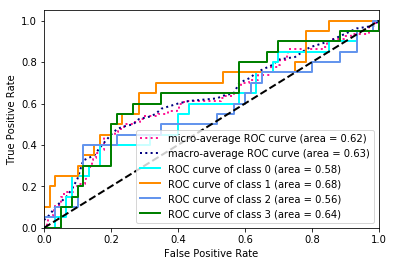

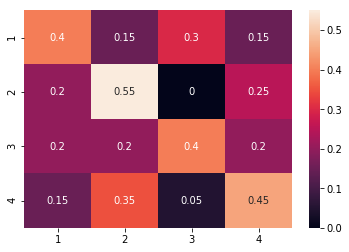

(633430, 60)
(796, 250, 60)
{'rmse': 1.7125, 'tr_acc': 0.9399441340782123, 'acc': 0.4, 'pre': array([0.35, 0.55, 0.3 , 0.4 ]), 'rec': array([0.53846154, 0.35483871, 0.375     , 0.4       ]), 'f1s': array([0.42424242, 0.43137255, 0.33333333, 0.4       ])}
l1b


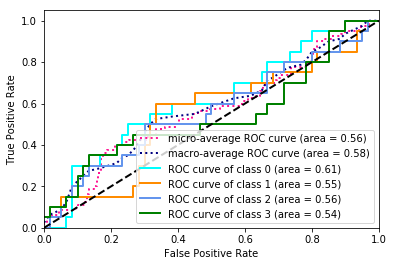

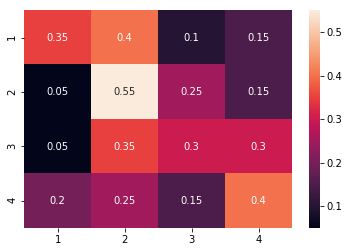

In [55]:
reports = []
for subject in ['k3b', 'k6b', 'l1b']:
    reports.append(evaluate(subject, window_size=250, stride=150))

In [56]:
reports

[{'rmse': 0.7416666666666667,
  'tr_acc': 0.483271375464684,
  'acc': 0.5916666666666667,
  'pre': array([0.7       , 0.5       , 0.9       , 0.26666667]),
  'rec': array([0.56756757, 0.57692308, 0.5625    , 0.88888889]),
  'f1s': array([0.62686567, 0.53571429, 0.69230769, 0.41025641])},
 {'rmse': 1.975,
  'tr_acc': 0.9972067039106145,
  'acc': 0.45,
  'pre': array([0.4 , 0.55, 0.4 , 0.45]),
  'rec': array([0.42105263, 0.44      , 0.53333333, 0.42857143]),
  'f1s': array([0.41025641, 0.48888889, 0.45714286, 0.43902439])},
 {'rmse': 1.7125,
  'tr_acc': 0.9399441340782123,
  'acc': 0.4,
  'pre': array([0.35, 0.55, 0.3 , 0.4 ]),
  'rec': array([0.53846154, 0.35483871, 0.375     , 0.4       ]),
  'f1s': array([0.42424242, 0.43137255, 0.33333333, 0.4       ])}]